# Data loading, EDA, preprocessing

In [1]:
# let's free some memories first
import gc
gc.disable()

In [2]:
# libraries
import io
import os
from datetime import datetime

# data libraries
import pandas as pd
import numpy as np
from numpy import load
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# tensorflow libs
from tensorflow.keras.applications import EfficientNetB0, EfficientNetV2S
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from keras.utils import load_img , img_to_array 
import tensorflow as tf 
import cv2 

# sklearn related
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.utils import compute_class_weight 
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.pipeline import Pipeline
import splitfolders

# NLP related
import logging
import nltk
from nltk.corpus import stopwords
import re
from bs4 import BeautifulSoup
nltk.download('stopwords')
# Import stopwords with nltk.
from nltk.corpus import stopwords

import time

# Matplotlib configuration
font = { 'family': 'DejaVu Sans', 'weight': 'bold', 'size': 16 }
plt.rc('font', **font)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\patel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
np.random.seed(seed=42)

In [4]:
# running on local machine, 
# system details
# RAM : 32 GB
# CPU : 6 cores - 12 threads hyperthreading
# GPU 0, 1 CUDA (having some issues on windows tensorflow 2.10, might have to use WSL to leverage)
PATH = f"fashion_data\\data\\2024"
parquet_filenames_train = os.listdir(PATH + "\\train")
parquet_filenames_test = os.listdir(PATH + "\\test")

# to read the parquet file
def get_parquet_data(folder, N):
    """ Read parquet data from mutiple files """
    print(f"{N}")
    filenames = [ 
        f"{PATH}\\{folder}\\part-{i:05d}-of-{N:05d}.parquet" 
        for i in range(N)
    ]

    dataframes = [ 
        pd.read_parquet(filename) 
        for filename in filenames
    ]
    
    return pd.concat(dataframes)

In [5]:
# to load the base train and test files
# pertain the test dataframe for the future submission

df_train = get_parquet_data("train", len(parquet_filenames_train))
df_test = get_parquet_data("test", len(parquet_filenames_test))

362
362


In [7]:
df_train['bottom_category_id'].value_counts()

bottom_category_id
2070     98
46       98
1046     98
12186    98
2371     98
         ..
12405    44
11220    44
12356    43
6796     42
2101     42
Name: count, Length: 2609, dtype: int64

In [23]:
# Approach : 
# 1. download and convert the train, test files for the images
# 2. use split folders to create test, validation and test folders
# 3. why? : given DCU's jupyter file approach is storing a lot in-memory
#   and storing image files would help in testing
def save_images_groupby_productid(group_by, folder_name):
    for name, group in df_train.groupby(group_by):
        print(name)
        os.makedirs(f'{folder_name}/{name}')
        for row_index, row in group.iterrows():
            img_bytes = row['image/encoded']
            productid = row['product_id']
            # image
            bytes_io = io.BytesIO(img_bytes)
            image = Image.open(bytes_io)
            image.save(f'{folder_name}/{name}/{productid}.jpeg')

def just_save_images_productid(folder_name):
    os.makedirs(f'{folder_name}')
    for i, row in df_test.iterrows():
        img_bytes = row['image/encoded']
        productid = row['product_id']
        # image
        bytes_io = io.BytesIO(img_bytes)
        image = Image.open(bytes_io)
        image.save(f'{folder_name}/{productid}.jpeg')

In [5]:
pd.value_counts(df_train['top_category_text'], sort=True, ascending=False)

C:\Users\patel\AppData\Local\Temp\ipykernel_24964\1076920215.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.value_counts(df_train['top_category_text'], sort=True, ascending=False)


top_category_text
home_and_living                54600
craft_supplies_and_tools       33393
clothing                       30143
toys_and_games                 13835
accessories                    12416
paper_and_party_supplies       12207
bath_and_beauty                11327
weddings                       10143
shoes                           8892
art_and_collectibles            8716
jewelry                         7822
electronics_and_accessories     7474
bags_and_purses                 6650
books_movies_and_music          6262
pet_supplies                    5744
Name: count, dtype: int64

In [24]:
# Mappings and to understand the distribution and imbalance data
top_categories = df_train.groupby(['top_category_text','top_category_id']).first()
top_categories_map = dict(top_categories.index)

top_categories_map = {'accessories':0,
 'art_and_collectibles':1,
 'bags_and_purses':2,
 'bath_and_beauty':3,
 'books_movies_and_music':4,
 'clothing':5,
 'craft_supplies_and_tools':6,
 'electronics_and_accessories':7,
 'home_and_living':8,
 'jewelry':9,
 'paper_and_party_supplies':10,
 'pet_supplies':11,
 'shoes':12,
 'toys_and_games':13,
 'weddings':14}

primary_color = {0: 'beige',
 1: 'black',
 2: 'blue',
 3: 'bronze',
 4: 'brown',
 5: 'clear',
 6: 'copper',
 7: 'gold',
 9: 'green',
 10: 'orange',
 11: 'pink',
 12: 'purple',
 13: 'rainbow',
 14: 'red',
 15: 'rose gold',
 16: 'silver',
 17: 'white',
 18: 'yellow',
 19: 'other'}

second_color = {0: 'beige',
 1: 'black',
 2: 'blue',
 3: 'bronze',
 4: 'brown',
 5: 'clear',
 6: 'copper',
 7: 'gold',
 9: 'green',
 10: 'orange',
 11: 'pink',
 12: 'purple',
 13: 'rainbow',
 14: 'red',
 15: 'rose gold',
 16: 'silver',
 17: 'white',
 18: 'yellow',
 19: 'other'}



In [25]:
from sklearn.utils import class_weight

def split_test_val(df, field:str):
    '''
     to split the train and validation data 0.2 is the 
     default
     returns df_train and df_validation
    '''
    return train_test_split(
        df, 
        test_size=0.2, 
        stratify=df[field], 
        random_state=42)

def compute_class_weight_(field:str) -> dict:
    '''
    for tackling imbalanced data
    '''
    class_weights = class_weight.compute_class_weight('balanced',
        classes=np.unique(df_train[field]),y = df_train[field])

    return dict(enumerate(class_weights))

In [26]:
# to remove, trim and clean string data
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """   
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwords from text
    return text

# define X and Y, for train and the test dataset
def define_text_lables(df, text_field, class_field):
   """
    X, Y : text field and label 
   """
   stop = stopwords.words('english')
   df[text_field] = df[text_field].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))   
   df[text_field] = df[text_field].apply(clean_text)
   return  df[text_field].fillna('').values, df[class_field].values



In [27]:
# For tackling the imbalanced data,
# Option 1 : undersamping (would limit our train data)
# Option 2 : SMOTE (resource intensive and interfere with the veracity of data)
# Option 3 : Class weights (yes, seems like asking classifiers to balance the data with putting the weights)
classweights = compute_class_weight_('top_category_id')
classweights

{0: 1.232946735395189,
 1: 1.7563408291265106,
 2: 2.301994987468672,
 3: 1.3514846531885465,
 4: 2.444628979026935,
 5: 0.5078547810989837,
 6: 0.4584274149272802,
 7: 2.0482026581036483,
 8: 0.28037118437118436,
 9: 1.9570783260888094,
 10: 1.2540564157177576,
 11: 2.665088207985144,
 12: 1.7215774478932373,
 13: 1.106488374894591,
 14: 1.509244470735154}

In [28]:
# to try different classifier
# yard sticks
# On title field, not to consider other fields due to limited resources
# On CPU, CUDA isn`t working
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB, CategoricalNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
from sklearn.linear_model import LogisticRegression

def create_text_classification_pipeline():
    tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), 
                                   min_df = 2, 
                                   max_df = .95)
    return Pipeline([        
         ('vect', tfidf_vectorizer),
         ('tfidf', TfidfTransformer()),       
         ('clf', LogisticRegression(n_jobs=1, C=1e5,class_weight='balanced'))        
    ])

def model_predict(df_val, text_field, class_field, model):
    print(metrics.classification_report(df_val[class_field].values, model.predict(df_val[text_field])))

# Top category prediction

In [29]:
df_training_top_category, df_validation_top_category = split_test_val(df_train,'top_category_id')

In [30]:
X_top_category_texts, Y_top_category_labels = define_text_lables(df_training_top_category, text_field='title', class_field='top_category_id')
X_top_category_texts    

array(['curious creatures quartet',
       'cutting board cooktop cover impact shatter resistant glass d21 marbles 1 series marble waves',
       'beautiful vintage pinkishpeach 3piece set jacket tank skirt xs jo ed sophisticates 90s',
       ...,
       'engraved rolling pin christmas original shape decoration pattern laser engraved cookies decorating roller',
       'industrial decorative wall shelf design form staggered semifloating cube hanging shelf wood metal',
       'pink champagne luxury lip gloss'], dtype=object)

In [31]:
Y_top_category_labels.shape

(183699,)

In [32]:

text_clf_top_category = create_text_classification_pipeline()
text_clf_top_category.fit(X_top_category_texts, Y_top_category_labels)

c:\Users\patel\miniconda3\envs\etsy2\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('vect',
                 TfidfVectorizer(max_df=0.95, min_df=2, ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer()),
                ('clf',
                 LogisticRegression(C=100000.0, class_weight='balanced',
                                    n_jobs=1))])

In [33]:
model_predict(df_validation_top_category, 'title', 'top_category_id', text_clf_top_category)
predictions_top_category = text_clf_top_category.predict(df_test['title'])
predictions_top_category

              precision    recall  f1-score   support

           0       0.78      0.80      0.79      2483
           1       0.63      0.59      0.61      1743
           2       0.80      0.84      0.82      1330
           3       0.86      0.85      0.86      2265
           4       0.83      0.83      0.83      1252
           5       0.93      0.95      0.94      6029
           6       0.83      0.84      0.83      6679
           7       0.87      0.86      0.87      1495
           8       0.87      0.87      0.87     10920
           9       0.79      0.82      0.80      1564
          10       0.78      0.83      0.80      2442
          11       0.90      0.86      0.88      1149
          12       0.96      0.92      0.94      1778
          13       0.83      0.81      0.82      2767
          14       0.69      0.61      0.65      2029

    accuracy                           0.84     45925
   macro avg       0.82      0.82      0.82     45925
weighted avg       0.84   

array([ 6,  6,  6, ..., 10, 10, 10], dtype=int64)

### To try and experiment different approaches
- singular value decomposition for dimensionality reduction
- our problem here is, we have 15 classes and multiple text fields to choose from
- Since we don`t have any options to reduce/group the number of classes, our options are limited
1. Naive bayesian classifiers
2. Decision tress
3. KNN
4. ensemble
5. SVM

In [ ]:

texts = df_training_top_category['title'].astype('str')

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), 
                                   min_df = 2, 
                                   max_df = .95)

X = tfidf_vectorizer.fit_transform(texts) #features
y = df_training_top_category['top_category_text'].values #target

print (X.shape)
print(y.shape)

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import label_binarize

lsa = TruncatedSVD(n_components=100, 
                   n_iter=10, 
                   random_state=3)

X = lsa.fit_transform(X)

In [37]:
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB, CategoricalNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix

model_dict = {
              'Dummy' : DummyClassifier(random_state=3),
              'Stochastic Gradient Descent' : SGDClassifier(random_state=3, loss='log_loss'),
              'Random Forest': RandomForestClassifier(random_state=3),
              'Decsision Tree': DecisionTreeClassifier(random_state=3),
              'AdaBoost': AdaBoostClassifier(random_state=3),
              'Gaussian Naive Bayes': GaussianNB(),
              'K Nearest Neighbor': KNeighborsClassifier()
              }

#Train test split with stratified sampling for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = .3, 
                                                    shuffle = True, 
                                                    stratify = y, 
                                                    random_state = 3)

#Function to get the scores for each model in a df
def model_score_df(model_dict):   
    model_name, ac_score_list, p_score_list, r_score_list, f1_score_list = [], [], [], [], []
    for k,v in model_dict.items():   
        print(k)
        model_name.append(k)
        v.fit(X_train, y_train)
        y_pred = v.predict(X_test)
        ac_score_list.append(accuracy_score(y_test, y_pred))
        p_score_list.append(precision_score(y_test, y_pred, average='macro'))
        r_score_list.append(recall_score(y_test, y_pred, average='macro'))
        f1_score_list.append(f1_score(y_test, y_pred, average='macro'))
        model_comparison_df = pd.DataFrame([model_name, ac_score_list, p_score_list, r_score_list, f1_score_list]).T
        model_comparison_df.columns = ['model_name', 'accuracy_score', 'precision_score', 'recall_score', 'f1_score']
        model_comparison_df = model_comparison_df.sort_values(by='f1_score', ascending=False)
    return model_comparison_df

model_score_df(model_dict)

Dummy


c:\Users\patel\miniconda3\envs\etsy2\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Stochastic Gradient Descent
Random Forest
Decsision Tree
AdaBoost


c:\Users\patel\miniconda3\envs\etsy2\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Gaussian Naive Bayes
K Nearest Neighbor


,model_name,accuracy_score,precision_score,recall_score,f1_score
2,Random Forest,0.666594,0.713579,0.588621,0.63269
6,K Nearest Neighbor,0.610851,0.604234,0.571431,0.583582
3,Decsision Tree,0.494574,0.452328,0.452677,0.452382
4,AdaBoost,0.483742,0.475492,0.413016,0.415131
5,Gaussian Naive Bayes,0.375649,0.446595,0.429045,0.404956
1,Stochastic Gradient Descent,0.506496,0.685906,0.339838,0.396768
0,Dummy,0.237779,0.015852,0.066667,0.025614


## Checkpoint 1. top_category_id
- save the model, prediction
- save the excel file storing the top_category_id predictions

In [83]:
# for the text category
df_test["top_category_id"] = predictions_top_category

In [ ]:
# Save please!!
df_test.to_csv('top_category_10th.csv', index=False)

In [18]:
# Create a new feature adding the prediction text for the bottom_category predictions
# optional step, don`t need to perform if it's not improving the f1 scores
# df_test['new_feature'] = df_test["top_category_text"] + ' ' + df_test["title"]

In [19]:
# df_test[["top_category_text","title","new_feature"]]

,top_category_text,title,new_feature
0,craft_supplies_and_tools,"Classroom Valentine Favors, Valentine Pencils,...",craft_supplies_and_tools Classroom Valentine F...
1,craft_supplies_and_tools,5 Colour Slatepencils In One Pack Order NOw,craft_supplies_and_tools 5 Colour Slatepencils...
2,craft_supplies_and_tools,"No 2 Pencils by Associated Commercial, #2 Wri...",craft_supplies_and_tools No 2 Pencils by Assoc...
3,craft_supplies_and_tools,"Personalized Carpenter Pencils, Engraved Carpe...",craft_supplies_and_tools Personalized Carpente...
4,craft_supplies_and_tools,Vintage 1960&#39;s Autopoint mechanical pencil...,craft_supplies_and_tools Vintage 1960&#39;s Au...
...,...,...,...
7,paper_and_party_supplies,Dinosaur Rice Krispies Treats 0.78oz Wrapper P...,paper_and_party_supplies Dinosaur Rice Krispie...
8,paper_and_party_supplies,"Strawberry Printable Candy Bar Wrapper, Snack ...",paper_and_party_supplies Strawberry Printable ...
9,paper_and_party_supplies,Boy Birthday Party Thank You Candy Bar Wrapper...,paper_and_party_supplies Boy Birthday Party Th...
10,paper_and_party_supplies,Circus Candy bar 1.55oz PRINTABLE Treats Circu...,paper_and_party_supplies Circus Candy bar 1.55...


# Bottom category 

In [62]:
# Define the fractions 
# we can train with everything have to do better memory management
# for the safer side, let's keep 0.5
df_train_bottom = df_train.groupby('bottom_category_id').sample(frac=0.5)


In [65]:
# df_train_bottom['new_feature'] = df_train_bottom["top_category_text"] + ' ' + df_train_bottom["title"]

In [63]:
df_training_bottom_category, df_validation_bottom_category = split_test_val(df_train_bottom,'bottom_category_id')

In [64]:
df_training_bottom_category.shape[0]

91864

In [66]:
X_bottom_category_texts, Y_bottom_category_labels = define_text_lables(df_training_bottom_category, text_field='title', class_field='bottom_category_id')
X_bottom_category_texts


array(['paper_and_party_supplies minimalist monthly budget planner tracker elegant personal finance organizer effective budgeting five stylish color schemes',
       'books_movies_and_music elephant coloring book coloring books adults elephants zentangle coloring pages floral mandala coloring jungle coloring gifts wild',
       'shoes bitcoin sneakers', ...,
       'clothing neutral boho florals bummies tiny knot top knot headband set baby girl clothes toddler diaper cover cute high waisted shorts',
       'accessories biscotti mens suspenders linen solid wedding suspenders',
       'home_and_living stamford opium incense stick aromatherapy genuine perfumery materials long burning joss incense sticks hex 12 pack'],
      dtype=object)

In [67]:
Y_bottom_category_labels

array([12487,   339,  1477, ..., 11152,     5,  1007], dtype=int64)

In [68]:
def create_text_classification_pipeline():
    tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), 
                                   min_df = 2, 
                                   max_df = .95)
    return Pipeline([
        #('vect', CountVectorizer()),
         ('vect', tfidf_vectorizer),
         ('tfidf', TfidfTransformer()),
        #('clf', CategoricalNB())
        # ('clf', LogisticRegression(n_jobs=1, C=1e5,class_weight='balanced'))
        # ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),               
         ('clf', MultinomialNB()),
    ])

In [69]:
text_clf_bottom_category = create_text_classification_pipeline()


In [70]:
text_clf_bottom_category.fit(X_bottom_category_texts, Y_bottom_category_labels)

Pipeline(steps=[('vect',
                 TfidfVectorizer(max_df=0.95, min_df=2, ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer()), ('clf', MultinomialNB())])

In [71]:
model_predict(df_validation_bottom_category, 'title', 'bottom_category_id', text_clf_bottom_category)

predictions_bottom_category = text_clf_bottom_category.predict(df_test['title'])

c:\Users\patel\miniconda3\envs\etsy2\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\patel\miniconda3\envs\etsy2\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\patel\miniconda3\envs\etsy2\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           1       0.00      0.00      0.00         9
           2       1.00      0.40      0.57        10
           3       0.57      0.89      0.70         9
           4       0.50      0.78      0.61         9
           5       0.58      0.70      0.64        10
           6       0.00      0.00      0.00         9
           7       0.67      0.44      0.53         9
           8       0.69      1.00      0.82         9
           9       0.50      0.11      0.18         9
          10       0.38      0.33      0.35         9
          11       0.75      0.67      0.71         9
          12       0.62      0.56      0.59         9
          13       0.62      0.89      0.73         9
          14       0.82      1.00      0.90         9
          15       0.50      1.00      0.67         9
          16       0.33      0.44      0.38         9
          17       0.25      0.33      0.29         9
          18       0.67    

## Checkpoint 2 : bottom_category_id
- save the model, file
- testing


In [72]:
# for the text category
df_test["bottom_category_id"] = predictions_bottom_category

In [ ]:
# it's always good to take the periodic backup
df_test.to_csv('checkpoint_bottom_category_1001.csv', index=False)

In [73]:
# just to verify the distribution of our predictions
pd.value_counts(
    df_test['bottom_category_id'], 
    sort=True, ascending=False)

C:\Users\patel\AppData\Local\Temp\ipykernel_13472\2071731108.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.value_counts(


bottom_category_id
1115     120
11143     44
532       37
1279      36
1942      34
        ... 
9          1
6793       1
6782       1
963        1
1667       1
Name: count, Length: 2523, dtype: int64

In [105]:
# df_test[["title","bottom_category_text"]]
df_test[["title","bottom_category_id"]]

,title,bottom_category_text
0,"Classroom Valentine Favors, Valentine Pencils,...",paper_and_party_supplies.paper.greeting_cards....
1,5 Colour Slatepencils In One Pack Order NOw,shoes.gender_neutral_adult_shoes
2,"No 2 Pencils by Associated Commercial, #2 Wri...",craft_supplies_and_tools.pens_pencils_and_mark...
3,"Personalized Carpenter Pencils, Engraved Carpe...",craft_supplies_and_tools.pens_pencils_and_mark...
4,Vintage 1960&#39;s Autopoint mechanical pencil...,craft_supplies_and_tools.pens_pencils_and_mark...
...,...,...
7,Dinosaur Rice Krispies Treats 0.78oz Wrapper P...,paper_and_party_supplies.paper.gift_wrapping.c...
8,"Strawberry Printable Candy Bar Wrapper, Snack ...",paper_and_party_supplies.paper.gift_wrapping.c...
9,Boy Birthday Party Thank You Candy Bar Wrapper...,paper_and_party_supplies.paper.gift_wrapping.c...
10,Circus Candy bar 1.55oz PRINTABLE Treats Circu...,paper_and_party_supplies.paper.gift_wrapping.c...


### EDA
- let's understand the HSV and BGR values of the saved images to 
- understand the problem and complications 
- Map BGR and HSV values and try to fetch the colors out of images

- Observations
    - Images contain multiple multiple objects and colors and HSV values
    - Some HSV values are overlapping 
    - Solving with just OpenCV doesn`t seem to be a viable option

In [ ]:
# save image for the primary color category
save_images_groupby_productid('primary_color_id','primary_color_ds')
just_save_images_productid('main_test')

In [ ]:
splitfolders.ratio("primary_color_ds", output="output",
     seed=1337, ratio=(.8, .1, .1), group_prefix=None, move=False) # default values

In [13]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
 
#lower and upper bounds of each color in hsv space
lower = {
    'beige': ([32, 10, 96]), 
    'black': ([0, 0, 0]), 
    'blue': ([230,100,100]), 
    'bronze': ([20,76,81]), 
    'brown': ([22, 100, 59]), 
    'clear': ([185, 3, 99]), 
    'copper': ([19,72,72]), 
    'gold': ([42, 100, 100]), 
    'green': ([110, 100, 100]), 
    'orange': ([39,100,100]), 
    'pink': ([340, 25, 100]), 
    'purple': ([267, 87, 94]), 
    'rainbow': ([272, 100, 83]), 
    'red':([0,100,100]), 
    'rose gold':([341, 40, 72]), 
    'silver':([0, 0, 75]),    
    'white':([0,0,100]), 
    'yellow':([50, 100, 100])
    } 

upper = {
    'beige': ([52, 255, 255]), 
    'black': ([10, 255, 255]), 
    'blue': ([250, 255, 255]), 
    'bronze': ([40, 255, 255]), 
    'brown': ([42, 255, 255]), 
    'clear': ([205, 255, 255]), 
    'copper': ([39, 255, 255]), 
    'gold': ([62, 255, 255]), 
    'green': ([130, 255, 255]), 
    'orange': ([49, 255, 255]), 
    'pink': ([360, 255, 255]), 
    'purple': ([287, 255, 255]), 
    'rainbow': ([292, 255, 255]), 
    'red':([10,255,255]), 
    'rose gold':([361, 255, 255]), 
    'silver':([2,255,255]),     
    'white':([3,255,255]), 
    'yellow':([70, 255, 255])
    }

#BGR tuple of each color 
colors = { # bgr format
    'beige': (220,245,245), 
    'black':(0,0,0), 
    'blue':(255,0,0), 
    'bronze':(50,127,205),
    'brown':(0,75,150),
    'clear':(252,250,244),
    'copper':(51,115,184),
    'gold':(0,223,255),
    'green':(0,255,0),
    'orange':(0,165,255),
    'pink':(203,192,255),
    'purple':(240,32,160),
    'rainbow':(211,0,148),
    'red':(0,0,255),
    'rose gold':(121,110,183),
    'silver':(192,192,192),     
    'white':(255, 255, 255), 
    'yellow':(0,255,255)   
    }

frame = cv2.imread("primary_color_ds/rose gold/1665967183.jpeg")
frame2 = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)

 
blurred = cv2.GaussianBlur(frame, (11, 11), 0)
hsv = cv2.cvtColor(blurred, cv2.COLOR_BGR2HSV)

mlist=[]
ks=[]

for (key, value) in upper.items():
    kernel = np.ones((2,2),np.uint8)    
    mask = cv2.inRange(hsv, np.array(lower[key]), np.array(upper[key]))
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    mask = cv2.dilate(mask, kernel, iterations=1)
    mlist.append(mask)
    cnts,_ = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if len(cnts)>=1:        
        ks.append(key)
        
print(ks)    


['beige', 'black', 'bronze', 'brown', 'copper', 'gold', 'green', 'orange', 'red', 'silver', 'white', 'yellow']


In [20]:
# hyperparameters
start_time = time.time()
IMAGE_SIZE=224
NUM_CLASSES_Primary_color = 19 
BATCH_SIZE = 64
path_for_saved_model = "primary-color-efficientnet.h5"

# train, test and the validation data;
train_path = "output/train"
validation_path = "output/val"
test_path = "output/test"
main_test_path = "main_test"

In [123]:
train_ds_primary_color = tf.keras.utils.image_dataset_from_directory(
  train_path,
  labels = "inferred",
  label_mode = "categorical",
  color_mode = "rgb", 
  image_size=(IMAGE_SIZE, IMAGE_SIZE),  
  batch_size=BATCH_SIZE,
  seed=123)

Found 183692 files belonging to 19 classes.


In [124]:
val_ds_primary_color = tf.keras.utils.image_dataset_from_directory(
  validation_path,
   labels = "inferred",
  label_mode = "categorical",
  color_mode = "rgb",
  image_size=(IMAGE_SIZE, IMAGE_SIZE),   
  batch_size=BATCH_SIZE,
  seed=123)

Found 22952 files belonging to 19 classes.


In [125]:
# type and the spape to understand the nature

print(train_ds_primary_color)

for image_batch, labels_batch in train_ds_primary_color:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

for image_batch, labels_batch in val_ds_primary_color:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 19), dtype=tf.float32, name=None))>
(64, 224, 224, 3)
(64, 19)
(64, 224, 224, 3)
(64, 19)


In [129]:
# Ensures that the model receives new variations of the images at each epoch

train_generator_primary_color = ImageDataGenerator().flow_from_directory(train_path, target_size=(IMAGE_SIZE,IMAGE_SIZE), batch_size=BATCH_SIZE)

validation_generator_primary_color = ImageDataGenerator().flow_from_directory(validation_path, target_size=(IMAGE_SIZE,IMAGE_SIZE), batch_size=BATCH_SIZE)


Found 183692 images belonging to 19 classes.
Found 22952 images belonging to 19 classes.


In [130]:
class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(train_generator_primary_color.classes),
                                        y = train_generator_primary_color.classes                                                    
                                    )
class_weights = dict(zip(np.unique(train_generator_primary_color.classes), class_weights))
class_weights

{0: 0.9773554387383745,
 1: 0.39400114108729317,
 2: 0.43709028437090286,
 3: 4.892712550607287,
 4: 0.6083181274775058,
 5: 2.6589658965896588,
 6: 6.528021607022282,
 7: 1.2629653821032005,
 8: 0.775798427218745,
 9: 2.1484444444444444,
 10: 1.3450194769059545,
 11: 0.7539577321999532,
 12: 1.7903703703703704,
 13: 2.7442520579051943,
 14: 0.7631828228607515,
 15: 14.626323751891075,
 16: 1.1234022774808274,
 17: 0.4224232096823524,
 18: 1.6715076071922546}

In [133]:
# Build the model 
baseModel = EfficientNetV2S(weights= "imagenet", include_top=False , input_shape=(IMAGE_SIZE,IMAGE_SIZE,3))

x = baseModel.output
x = GlobalAveragePooling2D()(x)
x = Dense(512 , activation='relu')(x)
x = Dense(256 , activation='relu')(x)
x = Dense(128 , activation='relu')(x)

predictLayer = Dense(NUM_CLASSES_Primary_color, activation='softmax')(x)

model = Model(inputs= baseModel.input , outputs=predictLayer)

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 stem_conv (Conv2D)             (None, 112, 112, 24  648         ['rescaling[0][0]']              
                                )                                                                 
                                                                                              

 block6g_drop (Dropout)         (None, 7, 7, 256)    0           ['block6g_project_bn[0][0]']     
                                                                                                  
 block6g_add (Add)              (None, 7, 7, 256)    0           ['block6g_drop[0][0]',           
                                                                  'block6f_add[0][0]']            
                                                                                                  
 block6h_expand_conv (Conv2D)   (None, 7, 7, 1536)   393216      ['block6g_add[0][0]']            
                                                                                                  
 block6h_expand_bn (BatchNormal  (None, 7, 7, 1536)  6144        ['block6h_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block6h_e

In [134]:
# freeze the EfficientNetV2S pre-trained layers just to improve the computation efficiency
# can experiment with limiting the trainable layers
for layer in model.layers: # 
    layer.trainable = False

print(model.summary())


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 stem_conv (Conv2D)             (None, 112, 112, 24  648         ['rescaling[0][0]']              
                                )                                                                 
                                                                                              

In [136]:
# have set it to just 1 because of lack of time and resources
# since we have set the early stopping callback so we can set up to 10
epochs = 1 
optimizer = Adam(learning_rate = 0.0001)

model.compile(loss="categorical_crossentropy", optimizer=optimizer , metrics=['accuracy'])

# Define EarlyStopping callback
# regularization to prevent overfitting, finding the right balance
# four components for the early stopping
# 1. validation set yup, it's given
# 2. metric to measure
# 3. ability to save the best model
# 4. halt trigger, as soon as we're done training the datasets
callbacks = [
    ModelCheckpoint(path_for_saved_model, verbose=1, save_best_only=True , monitor="val_accuracy"),
    ReduceLROnPlateau(monitor="val_accuracy", patience=4, factor=0.1 , verbose=1, min_lr=1e-6),
    EarlyStopping(monitor="val_accuracy", patience=5, verbose=1) ]
# 
# early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

# train
model.fit(train_generator_primary_color , validation_data=validation_generator_primary_color , epochs=epochs, class_weight=class_weights, callbacks=callbacks)

end_time = time.time()
execution_time_seconds  = end_time - start_time
execution_time_minutes = execution_time_seconds / 60

print(f"The code took {execution_time_minutes:.6f} minutes to execute.")

model.save(path_for_saved_model)

2871/2871 [==============================] - ETA: 0s - loss: 2.4675 - accuracy: 0.2359
Epoch 1: val_accuracy improved from -inf to 0.28185, saving model to model/trail_uno\effnet-color-weights-15.h5
2871/2871 [==============================] - 9911s 3s/step - loss: 2.4675 - accuracy: 0.2359 - val_loss: 2.3565 - val_accuracy: 0.2818 - lr: 1.0000e-04
The code took 168.985285 minutes to execute.


## Checkpoint 3 : Primary_color_id
- save the model
- save the df_test file
- prediction and testing 

In [23]:
# get the classes 
# path_for_saved_model
CLASSES = os.listdir(train_path)
num_classes = len(CLASSES)
model_primary_color = tf.keras.models.load_model("model/trail_uno/effnet-color-weights-15.h5")

In [139]:
def prepareImage(pathForImage) :
    image = load_img(pathForImage , target_size=(IMAGE_SIZE, IMAGE_SIZE))
    img_result = img_to_array(image)
    img_result = np.expand_dims(img_result , axis=0)
    img_result = img_result / 255.
    return img_result

# for the testing
testImagePath = "output/test/black/23726088.jpeg"

#
ImgForModel = prepareImage(testImagePath)
resultArray = model_primary_color.predict(ImgForModel , verbose=1)
answer = np.argmax(resultArray , axis=1)

print(answer)
index = answer[0]
desc = CLASSES[index]

print("The predicted class is : " + desc)

1/1 [==============================] - 4s 4s/step
[5]
The predicted class is : clear


In [ ]:
datagen = ImageDataGenerator()

test_data = datagen.flow_from_directory('main_test/', batch_size=64, class_mode=None)

In [24]:

resultArray = model_primary_color.predict(test_data , verbose=1)
answer = np.argmax(resultArray, axis=1)    
df_test['primary_color_id'] = answer

399/399 [==============================] - 1490s 4s/step


In [ ]:
df_test.to_csv('checkpoint_primary_color_11.csv',index=False)

C:\Users\patel\AppData\Local\Temp\ipykernel_4340\3784692834.py:8: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.value_counts(


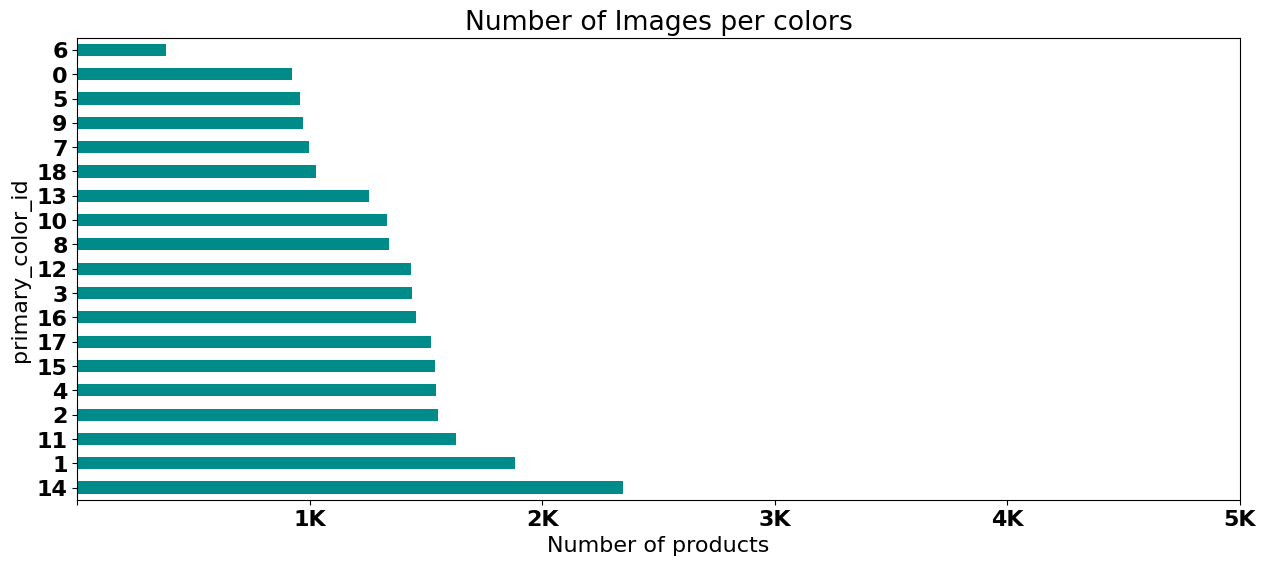

In [29]:
# testing the prediction distribution to make sure
figsize = (15, 6)
column = 'primary_color_id'
x_limit = 6000
x_step = 1000
color = 'darkcyan'
    
figure, ax = plt.subplots(figsize=figsize)
pd.value_counts(
    df_test[column], 
    sort=True, ascending=False).plot.barh(color=color)
plt.title(f"Number of Images per colors")
xlabels = [f'{x // 1000:,}K' for x in range(0, x_limit, x_step)]
plt.xticks(range(0, x_limit, x_step), xlabels)
plt.xlabel('Number of products')
plt.setp(ax.get_xticklabels()[0], visible=False)
plt.show()

In [9]:
# hyperparameters for the model
IMAGE_SIZE = 224
BATCH_SIZE = 64
NUM_CLASSES = 19

path_for_saved_model = "secondary-color-efficientnet.h5"
train_path_secondary = 'output_secondary/train'
validation_path_secondary = 'output_secondary/val'
test_path_secondary = 'main_test'

In [ ]:
# generate images for the training dataset
save_images_groupby_productid('secondary_color_text','secondary_color_ds')

In [42]:
splitfolders.ratio("secondary_color_ds", output="output_secondary",
    seed=1337, ratio=(.8, .1, .1), group_prefix=None, move=False) # default values

Copying files: 229624 files [21:41, 176.40 files/s]


C:\Users\patel\AppData\Local\Temp\ipykernel_4340\2964015144.py:2: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.value_counts(


<Axes: ylabel='secondary_color_id'>

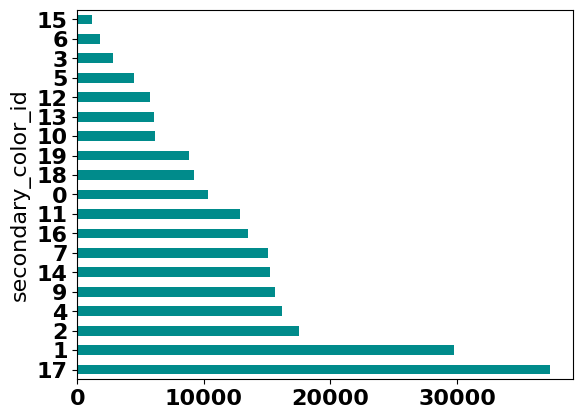

In [39]:
column = 'secondary_color_id'
pd.value_counts(
    df_train[column], 
    sort=True, ascending=False).plot.barh(color='darkcyan')

In [ ]:
train_ds_secondary_color = tf.keras.utils.image_dataset_from_directory(
  train_path_secondary,
  labels = "inferred",
  label_mode = "categorical",
  color_mode = "rgb", 
  image_size=(IMAGE_SIZE, IMAGE_SIZE),  
  batch_size=BATCH_SIZE,
  seed=123)

val_ds_secondary_color = tf.keras.utils.image_dataset_from_directory(
  validation_path_secondary,
   labels = "inferred",
  label_mode = "categorical",
  color_mode = "rgb",
  image_size=(IMAGE_SIZE, IMAGE_SIZE),   
  batch_size=BATCH_SIZE,
  seed=123)

In [ ]:
print(train_ds_secondary_color)

for image_batch, labels_batch in train_ds_secondary_color:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

for image_batch, labels_batch in val_ds_secondary_color:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

In [4]:
train_generator_secondary_color = ImageDataGenerator().flow_from_directory(train_path_secondary, target_size=(IMAGE_SIZE,IMAGE_SIZE), batch_size=BATCH_SIZE)

validation_generator_secondary_color = ImageDataGenerator().flow_from_directory(validation_path_secondary, target_size=(IMAGE_SIZE,IMAGE_SIZE), batch_size=BATCH_SIZE)

Found 183693 images belonging to 19 classes.
Found 22955 images belonging to 19 classes.


In [5]:
class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(train_generator_secondary_color.classes),
                                        y = train_generator_secondary_color.classes                                                    
                                    )
class_weights = dict(zip(np.unique(train_generator_secondary_color.classes), class_weights))
class_weights


{0: 1.1710335067319462,
 1: 0.4059477927266941,
 2: 0.6887549071439016,
 3: 4.321883161188622,
 4: 0.7485909896692952,
 5: 2.6960548331229637,
 6: 6.644709712425393,
 7: 0.8024612078003774,
 8: 0.7746837044534413,
 9: 1.9698558744048384,
 10: 1.3709660566617905,
 11: 0.9409296965040338,
 12: 2.1183287974537572,
 13: 1.9852264130552253,
 14: 0.7924633304572908,
 15: 10.296115688582478,
 16: 0.8943619455669701,
 17: 0.32372518438235215,
 18: 1.3100342319212666}

In [11]:
# Build the model 
baseModel = EfficientNetV2S(weights= "imagenet", include_top=False , input_shape=(IMAGE_SIZE,IMAGE_SIZE,3))

x = baseModel.output
x = GlobalAveragePooling2D()(x)
x = Dense(512 , activation='relu')(x)
x = Dense(256 , activation='relu')(x)
x = Dense(128 , activation='relu')(x)

predictLayer = Dense(19, activation='softmax')(x)

model = Model(inputs= baseModel.input , outputs=predictLayer)

print(model.summary())


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['input_2[0][0]']                
                                                                                                  
 stem_conv (Conv2D)             (None, 112, 112, 24  648         ['rescaling_1[0][0]']            
                                )                                                                 
                                                                                            

In [12]:
len(model.layers)

518

In [14]:
# freeze the EfficientNetV2S pre-trained layers just to improve the computation efficiency

for layer in model.layers: # until the last layers we add
    layer.trainable = False

print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['input_2[0][0]']                
                                                                                                  
 stem_conv (Conv2D)             (None, 112, 112, 24  648         ['rescaling_1[0][0]']            
                                )                                                                 
                                                                                            

In [8]:
gpus = tf.config.list_physical_devices("GPU")
gpus

[]

In [15]:
epochs = 10
optimizer = Adam(learning_rate = 0.0001)

model.compile(loss="categorical_crossentropy", optimizer=optimizer , metrics=['accuracy'])

# Define EarlyStopping callback
# regularization to prevent overfitting, finding the right balance
# four components for the early stopping
# 1. validation set yup, it's given
# 2. metric to measure
# 3. ability to save the best model
# 4. halt trigger, as soon as we're done training the datasets
callbacks = [
    ModelCheckpoint(path_for_saved_model, verbose=1, save_best_only=True , monitor="val_accuracy"),
    ReduceLROnPlateau(monitor="val_accuracy", patience=4, factor=0.1 , verbose=1, min_lr=1e-6),
    EarlyStopping(monitor="val_accuracy", patience=5, verbose=1) ]
# 
# early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

# train
model.fit(train_generator_secondary_color , validation_data=validation_generator_secondary_color , epochs=1, class_weight=class_weights, callbacks=callbacks)

model.save(path_for_saved_model)

2871/2871 [==============================] - ETA: 0s - loss: 2.7075 - accuracy: 0.1266
Epoch 1: val_accuracy improved from -inf to 0.15866, saving model to model/trail_uno\effnet-secondary-17.h5
2871/2871 [==============================] - 9594s 3s/step - loss: 2.7075 - accuracy: 0.1266 - val_loss: 2.6587 - val_accuracy: 0.1587 - lr: 1.0000e-04


## Checkpoint 4 : secondary color id
- save/load the final model
- save the df_test
- testing

In [16]:
# get the classes 
# path_for_saved_model

model_secondary_color = tf.keras.models.load_model(path_for_saved_model)

In [18]:
resultArray = model_secondary_color.predict(test_data, verbose=1)
answer = np.argmax(resultArray, axis=1)    
df_test['secondary_color_id'] = answer
df_test.to_csv('checkpoint-4-secondary-12.csv')

399/399 [==============================] - 1466s 4s/step


In [98]:
df_test[["product_id", "top_category_id", "bottom_category_id", "primary_color_id", "secondary_color_id"]]
# 661373440 for the testing

,product_id,top_category_id,bottom_category_id,primary_color_id,secondary_color_id
0,661373440,6,1279,14,11
1,1501009290,6,6248,18,3
2,1105447030,6,6751,12,15
3,1140081090,6,6404,14,12
4,793448890,6,6752,14,14
...,...,...,...,...,...
25509,869022010,10,9183,14,4
25510,954065860,10,9183,1,14
25511,1417634130,10,9183,15,14
25512,942614980,10,9183,14,5


# export


In [99]:
id_export = "dummy"
df_test[
    ["product_id", "top_category_id", "bottom_category_id"]
].to_parquet(f"predictions_{id_export}.parquet")